In [1]:
# !pip install -r requirements_eda.txt

In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports

from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports

from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2

from pycocotools.coco import COCO

# Other Imports

from tqdm.notebook import tqdm

LABELCOLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABELCOLORSWOUTNOFINDING = LABELCOLORS[:8]+LABELCOLORS[9:]

In [3]:
coco = COCO('../../dataset/train.json')
train_df = pd.DataFrame()
image_ids = []
class_name = []
class_id = []
area = []
x_min = []
y_min = []
x_max = []
y_max = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

for image_id in coco.getImgIds():
    imageinfo = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=imageinfo['id'])
    anns = coco.loadAnns(ann_ids)
    filename = imageinfo['file_name']

    for ann in anns:
        image_ids.append(filename)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        area.append(float(ann['area']))
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

train_df['image_id'] = image_ids
train_df['class_name'] = class_name
train_df['class_id'] = class_id
train_df['x_min'] = x_min
train_df['y_min'] = y_min
train_df['x_max'] = x_max
train_df['y_max'] = y_max
train_df['area'] = area

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [4]:
fig = px.histogram(train_df.image_id.value_counts(),
                   log_y=False, color_discrete_sequence=['indianred'], opacity=0.7,
                   labels={"value":"Number of Annotations Per Image"},
                   title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER IMAGE "
                   "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )

fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique Images</b>",
                  yaxis_title="<b>Count of All Object Annotations</b>",
                  )

fig.show()

In [5]:
fig = px.histogram(train_df.groupby('image_id')["class_id"].unique().apply(lambda x: len(x)),
                   log_y=False, color_discrete_sequence=['skyblue'], opacity=0.7,
                   labels={"value":"Number of Unique class"},
                   title="<b>DISTRIBUTION OF # OF Unique Class PER IMAGE"
                   "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )

fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique CLASS</b>",
                  yaxis_title="<b>Count of Unique IMAGE</b>",)

fig.show()

In [6]:
fig = px.bar(train_df.class_name.value_counts().sort_index(),
             color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
             color_discrete_sequence=LABELCOLORS, log_y=False,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class</b>",)

fig.update_layout(legend_title=None,
                 xaxis_title="",
                 yaxis_title="<b>Annotations Per Class</b>")

fig.show()

  0%|          | 0/23144 [00:00<?, ?it/s]

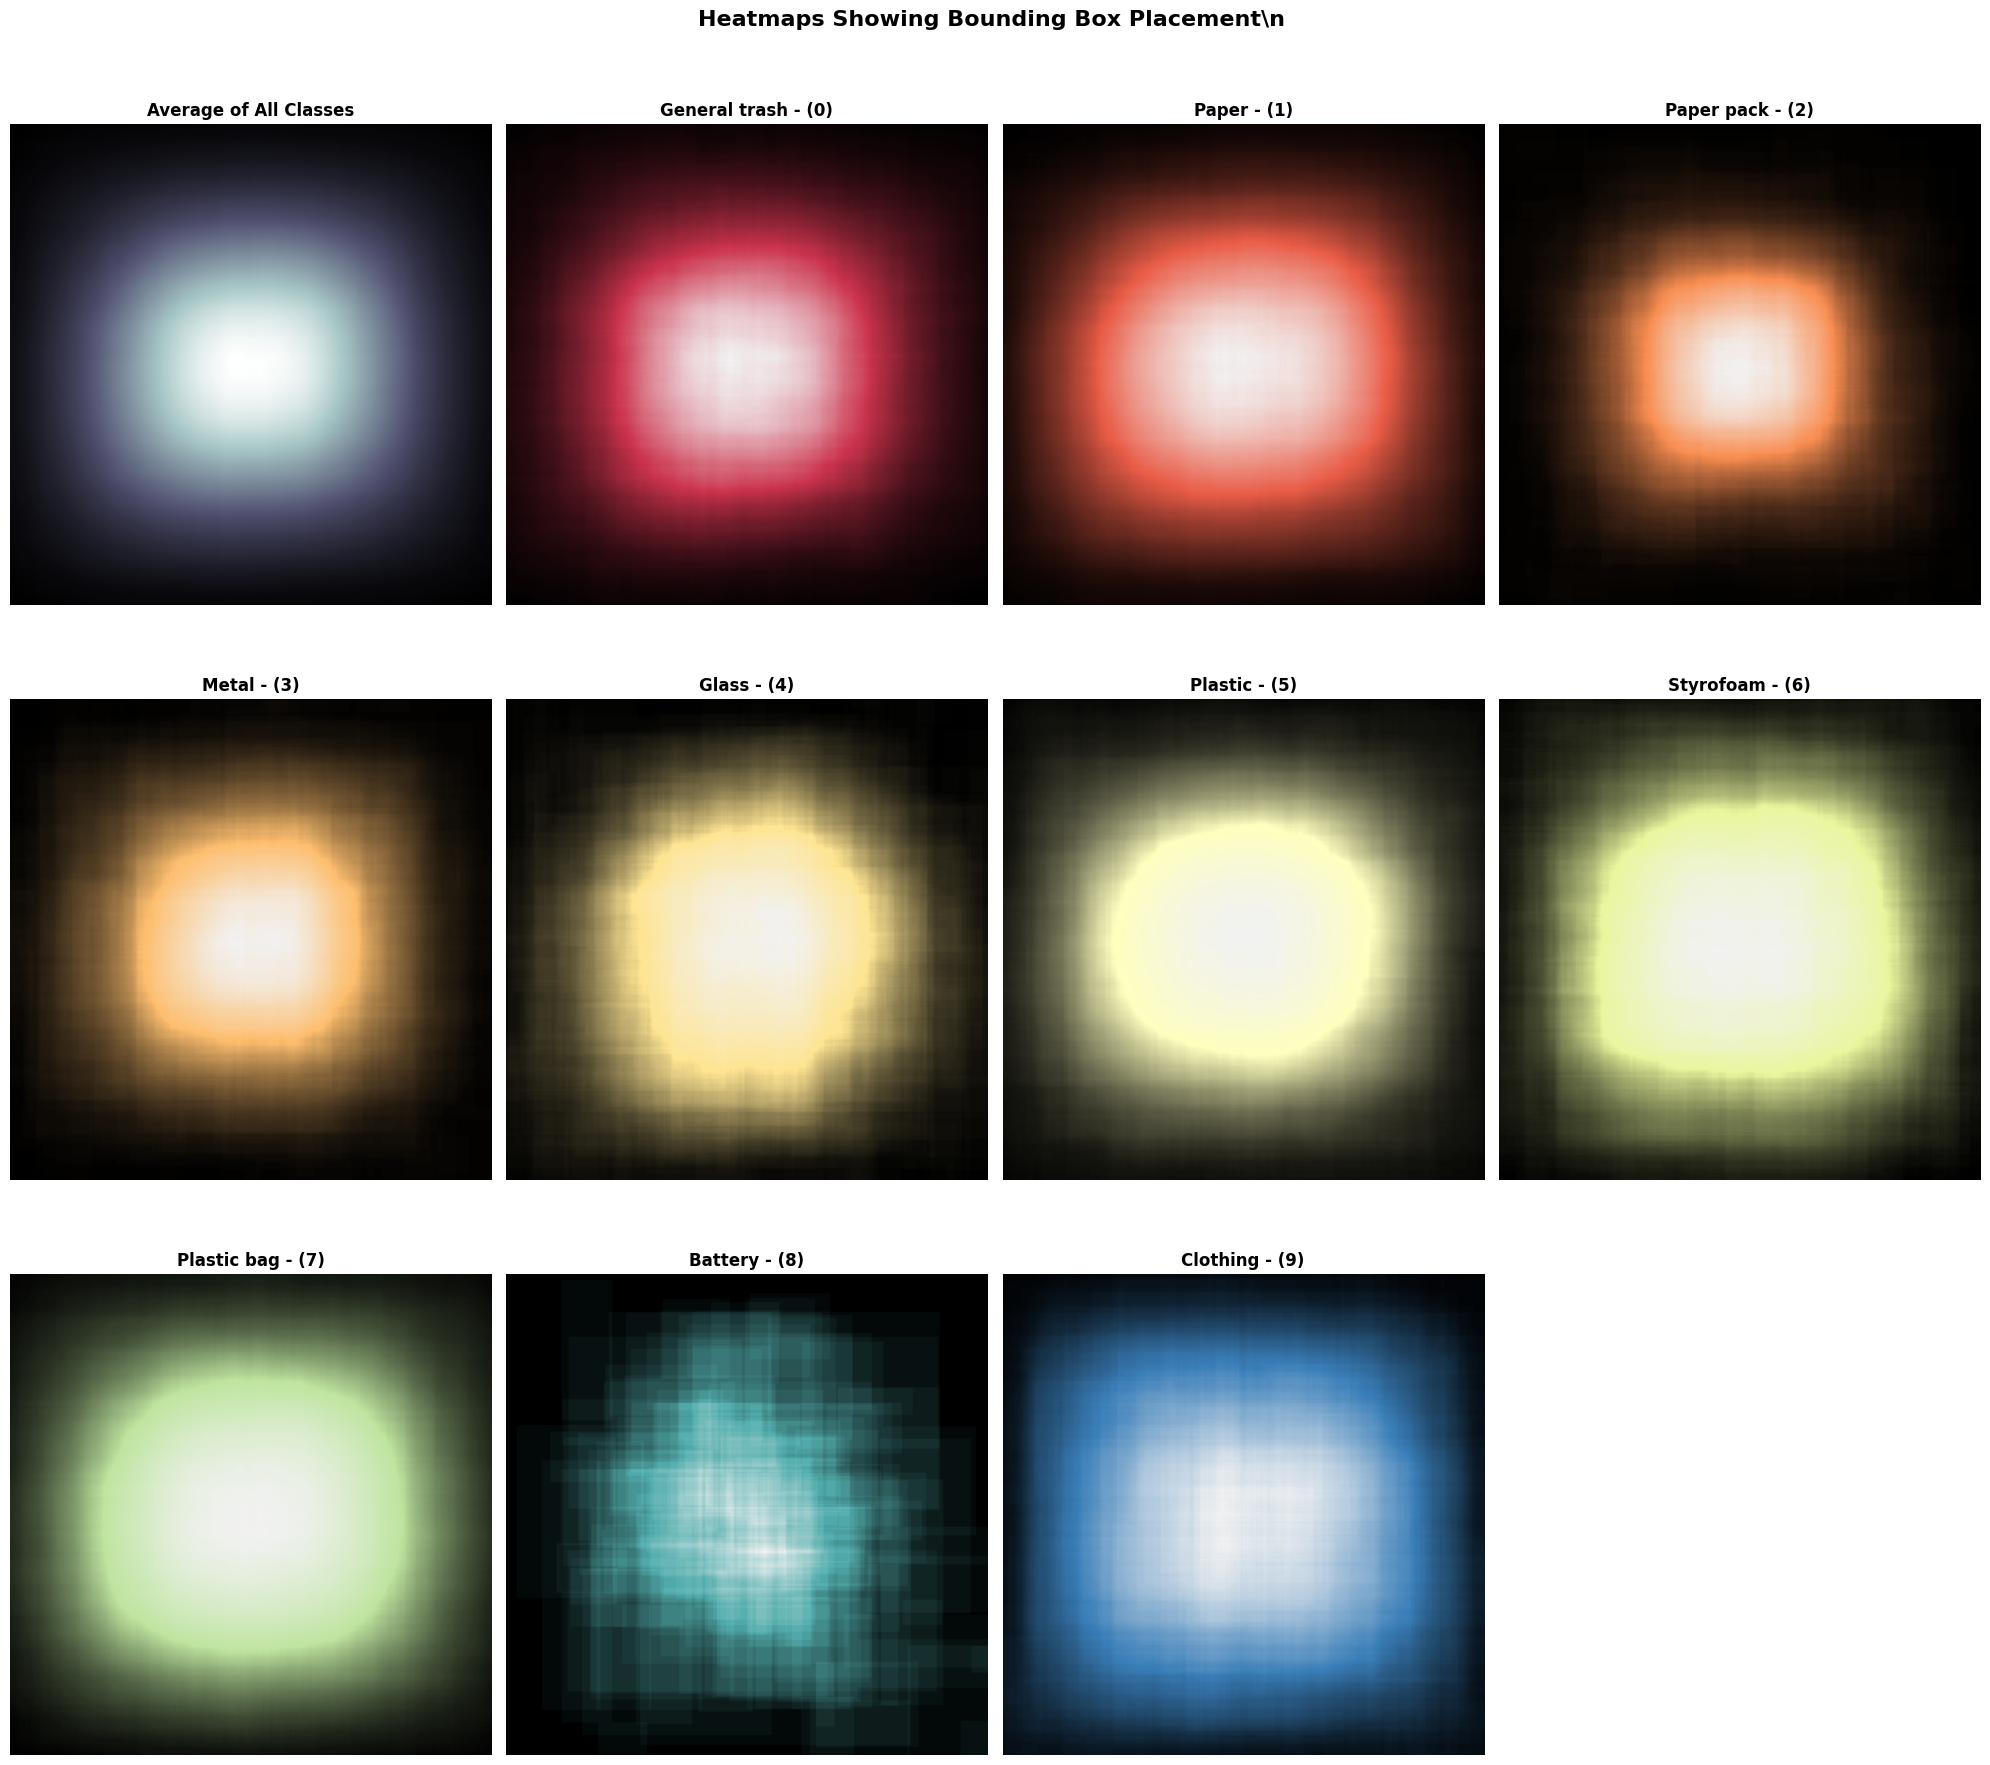

In [7]:
bbox_df = pd.DataFrame()
bbox_df['class_id'] = train_df['class_id'].values
bbox_df['class_name'] = train_df['class_name'].values
bbox_df['x_min'] = train_df['x_min'].values
bbox_df['x_max'] = train_df['x_max'].values
bbox_df['y_min'] = train_df['y_min'].values
bbox_df['y_max'] = train_df['y_max'].values
bbox_df['fracx_min'] = train_df['x_min'].values / 1024
bbox_df['fracx_max'] = train_df['x_max'].values / 1024
bbox_df['fracy_min'] = train_df['y_min'].values / 1024
bbox_df['fracy_max'] = train_df['y_max'].values / 1024
avesrcimg_height = 1024
avesrcimg_width = 1024

# DEFAULT

HEATMAP_SIZE = (avesrcimg_height, avesrcimg_width, 14)

# Initialize

heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bbox_np = bbox_df[["class_id", "fracx_min", "fracx_max", "fracy_min", "fracy_max"]].to_numpy()
bbox_np[:, 1:3] *= avesrcimg_width
bbox_np[:, 3:5] *= avesrcimg_height
bbox_np = np.floor(bbox_np).astype(np.int16)

# Color map stuff

custom_cmaps = [
    matplotlib.colors.LinearSegmentedColormap.from_list(
        colors=[(0.,0.,0.), c, (0.95,0.95,0.95)],
        name=f"custom{i}"
    ) for i,c in enumerate(sns.color_palette("Spectral", 11))
]

custom_cmaps.pop(8) # Remove No-Finding

for row in tqdm(bbox_np, total=bbox_np.shape[0]):
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1

fig = plt.figure(figsize=(20,25))
plt.suptitle("Heatmaps Showing Bounding Box Placement\\n ", fontweight="bold", fontsize=16)

for i in range(11):
    plt.subplot(4, 4, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"Average of All Classes", fontweight="bold")

    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"{classes[i-1]} - ({i - 1})", fontweight="bold")

    plt.axis(False)

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [8]:
bbox_df["fracbbox_area"] = (bbox_df["fracx_max"]-bbox_df["fracx_min"])*(bbox_df["fracy_max"]-bbox_df["fracy_min"])

# bboxdf["classidasstr"] = bboxdf["classid"].map(classes)

display(bbox_df.head())

fig = px.box(bbox_df.sort_values(by="class_name"), x="class_name", y="fracbbox_area", color="class_name",
             labels={"classname":"Class Name", "fracbbox_area":"BBox Area (%)"},
             title="<b>DISTRIBUTION OF BBOX AREAS AS % OF SOURCE IMAGE AREA"
             "<i><sub>(Some Upper Outliers Excluded For Better Visualization)</sub></i></b>")

fig.update_layout(showlegend=True,
                  yaxis_range=[-0.025, 1.1],
                  legend_title_text=None,
                  xaxis_title="",
                  yaxis_title="<b>Bounding Box Area %</b>",)

fig.show()

class_id     class_name  x_min  x_max  y_min  y_max  fracx_min  fracx_max   
0         0  General trash  197.6  745.4  193.7  663.4   0.192969   0.727930  \
1         3          Metal    0.0   57.6  407.4  588.0   0.000000   0.056250   
2         7    Plastic bag    0.0  144.6  455.6  637.2   0.000000   0.141211   
3         4          Glass  722.3  996.6  313.4  565.3   0.705371   0.973242   
4         5        Plastic  353.2  586.9  671.0  774.4   0.344922   0.573145   

   fracy_min  fracy_max  fracbbox_area  
0   0.189160   0.647852       0.245382  
1   0.397852   0.574219       0.009921  
2   0.444922   0.622266       0.025043  
3   0.306055   0.552051       0.065895  
4   0.655273   0.756250       0.023045

In [9]:
bbox_df["aspect_ratio"] = (bbox_df["x_max"]-bbox_df["x_min"])/(bbox_df["y_max"]-bbox_df["y_min"])

# Display average means for each class_id so we can examine the newly created Aspect Ratio Column

display(bbox_df.groupby("class_name").mean())

# Generate the bar plot

fig = px.bar(x=sorted(classes), y=bbox_df.groupby("class_name").mean()["aspect_ratio"],
             color=sorted(classes), opacity=0.85,
             color_discrete_sequence=LABELCOLORSWOUTNOFINDING,
             labels={"x":"Class Name", "y":"Aspect Ratio (W/H)"},
             title="<b>Aspect Ratios For Bounding Boxes By Class</b>",)

fig.update_layout(
    yaxis_title="<b>Aspect Ratio (W/H)</b>",
    xaxis_title=None,
    legend_title_text=None)

fig.add_hline(y=1, line_width=2, line_dash="dot",
             annotation_font_size=10,
             annotation_text="<b>SQUARE ASPECT RATIO</b>",
             annotation_position="bottom left",
             annotation_font_color="black")

fig.add_hrect(y0=0, y1=0.5, line_width=0, fillcolor="red", opacity=0.125,
             annotation_text="<b>>2:1 VERTICAL RECTANGLE REGION</b>",
             annotation_position="bottom right",
             annotation_font_size=10,
             annotation_font_color="red")

fig.add_hrect(y0=2, y1=3.5, line_width=0, fillcolor="green", opacity=0.04,
             annotation_text="<b>>2:1 HORIZONTAL RECTANGLE REGION</b>",
             annotation_position="top right",
             annotation_font_size=10,
             annotation_font_color="green")

fig.show()

class_id       x_min       x_max       y_min       y_max   
class_name                                                                
Battery             8.0  411.002516  639.876730  432.148428  647.143396  \
Clothing            9.0  335.697222  730.380128  346.516026  738.193590   
General trash       0.0  392.753707  618.990923  404.283737  619.753833   
Glass               4.0  410.682383  616.770265  398.284827  670.155703   
Metal               3.0  396.325962  647.355235  377.684722  634.891774   
Paper               1.0  384.916137  648.767191  384.417774  621.110941   
Paper pack          2.0  387.955741  632.852062  417.834671  637.919175   
Plastic             5.0  400.650357  640.025382  395.486035  626.166667   
Plastic bag         7.0  377.764175  653.141213  349.603109  650.812688   
Styrofoam           6.0  360.715439  659.862549  377.397150  629.704276   

               fracx_min  fracx_max  fracy_min  fracy_max  fracbbox_area   
class_name                                                                 
Battery         0.401370   0.624880   0.422020   0.631976       0.048075  \
Clothing        0.327829   0.713262   0.338395   0.720892       0.180578   
General trash   0.383549   0.604483   0.394808   0.605228       0.075207   
Glass           0.401057   0.602315   0.388950   0.654449       0.066126   
Metal           0.387037   0.632183   0.368833   0.620011       0.087399   
Paper           0.375895   0.633562   0.375408   0.606554       0.087780   
Paper pack      0.378863   0.618020   0.408042   0.622968       0.072590   
Plastic         0.391260   0.625025   0.386217   0.611491       0.077239   
Plastic bag     0.368910   0.637833   0.341409   0.635559       0.105245   
Styrofoam       0.352261   0.644397   0.368552   0.614946       0.093069   

               aspect_ratio  
class_name                   
Battery            1.428327  
Clothing           1.228279  
General trash      1.433186  
Glass              1.043987  
Metal              1.239462  
Paper              1.391648  
Paper pack         1.296333  
Plastic            1.288092  
Plastic bag        1.106761  
Styrofoam          1.474087

In [10]:
count = 0
for i, trashes in enumerate(train_df.image_id.value_counts(sort=False)):
    if trashes > 40:
        count += 1
        print("%d %d" % (i, trashes))
print(count)


394 48
946 55
1678 44
1797 42
1955 46
2416 46
2981 46
4047 52
4197 71
4492 42
4841 41
11


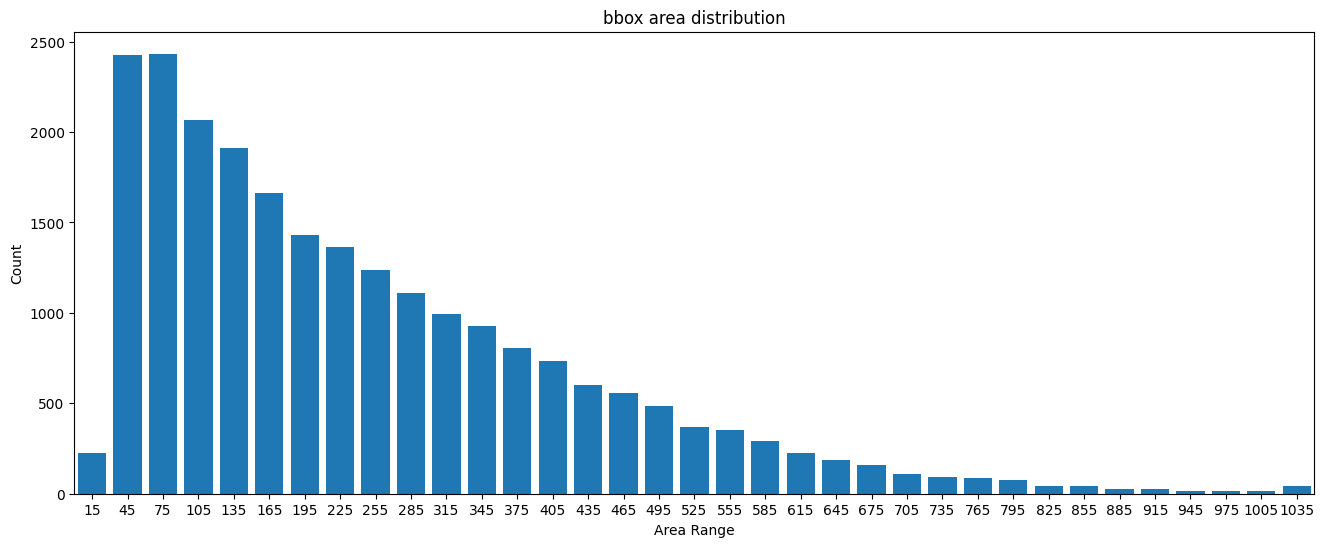

In [49]:
area_list = [0] * 35
for i in range(train_df.shape[0]):
    for j in range(0, 35):
        if (j * 30) ** 2 <= train_df.loc[i].area < ((j + 1) * 30) ** 2 :
            area_list[j] += 1
            break

plt.figure(figsize=(16,6))
bin_labels = [f'{i+15}' for i in range(0, 1050, 30)]
plt.bar(bin_labels, area_list)
plt.xlabel('Area Range')
plt.ylabel('Count')
plt.title('bbox area distribution')
plt.xlim(-0.5, len(bin_labels)-0.5)

plt.show()